In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt

from fme_diags.bias import compute_time_mean_bias, plot_time_mean_bias
from fme_diags.utils import load_config, open_autoregressive_inference, open_baseline

_ = xr.set_options(keep_attrs=True)

In [2]:
CONFIG_KEY = "topo-lr3.00e-04"
BASELINE_KEY = "baseline"
PREDS_START_DATE = "0031-01-01"
FLIP_LAT = False
CHUNKS = {"timestep": 178}

config = load_config("./preds.yaml")

In [3]:
ds = open_autoregressive_inference(config[CONFIG_KEY]["url"], start=PREDS_START_DATE, flip_lat=FLIP_LAT, chunks=CHUNKS)
ds

,Array,Chunk
Bytes,7.05 GiB,88.00 MiB
Shape,"(2, 1, 14597, 180, 360)","(2, 1, 178, 180, 360)"
Count,167 Tasks,83 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.05 GiB,88.00 MiB
Shape,"(2, 1, 14597, 180, 360)","(2, 1, 178, 180, 360)"
Count,167 Tasks,83 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [4]:
baseline_ds = open_baseline(config[BASELINE_KEY]["url"], start=PREDS_START_DATE, lat_coords=ds["lat"])
baseline_ds

,Array,Chunk
Bytes,3.52 GiB,1.19 MiB
Shape,"(14600, 180, 360)","(124, 7, 360)"
Count,3480 Tasks,3120 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.52 GiB,1.19 MiB
Shape,"(14600, 180, 360)","(124, 7, 360)"
Count,3480 Tasks,3120 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Compute time mean biases of generated and baseline OLR and OSR.

In [6]:
da_FLUT = ds["FLUT"]
time_mean_bias_FLUT = compute_time_mean_bias(
    da_FLUT.sel(source="prediction"),
    da_FLUT.sel(source="target")
)

[########################################] | 100% Completed | 33.3s


In [8]:
baseline_da_FLUT = baseline_ds["FLUT"]
baseline_time_mean_bias_FLUT = compute_time_mean_bias(
    baseline_da_FLUT,
    da_FLUT.sel(source="target")
)

[########################################] | 100% Completed |  1min  7.6s


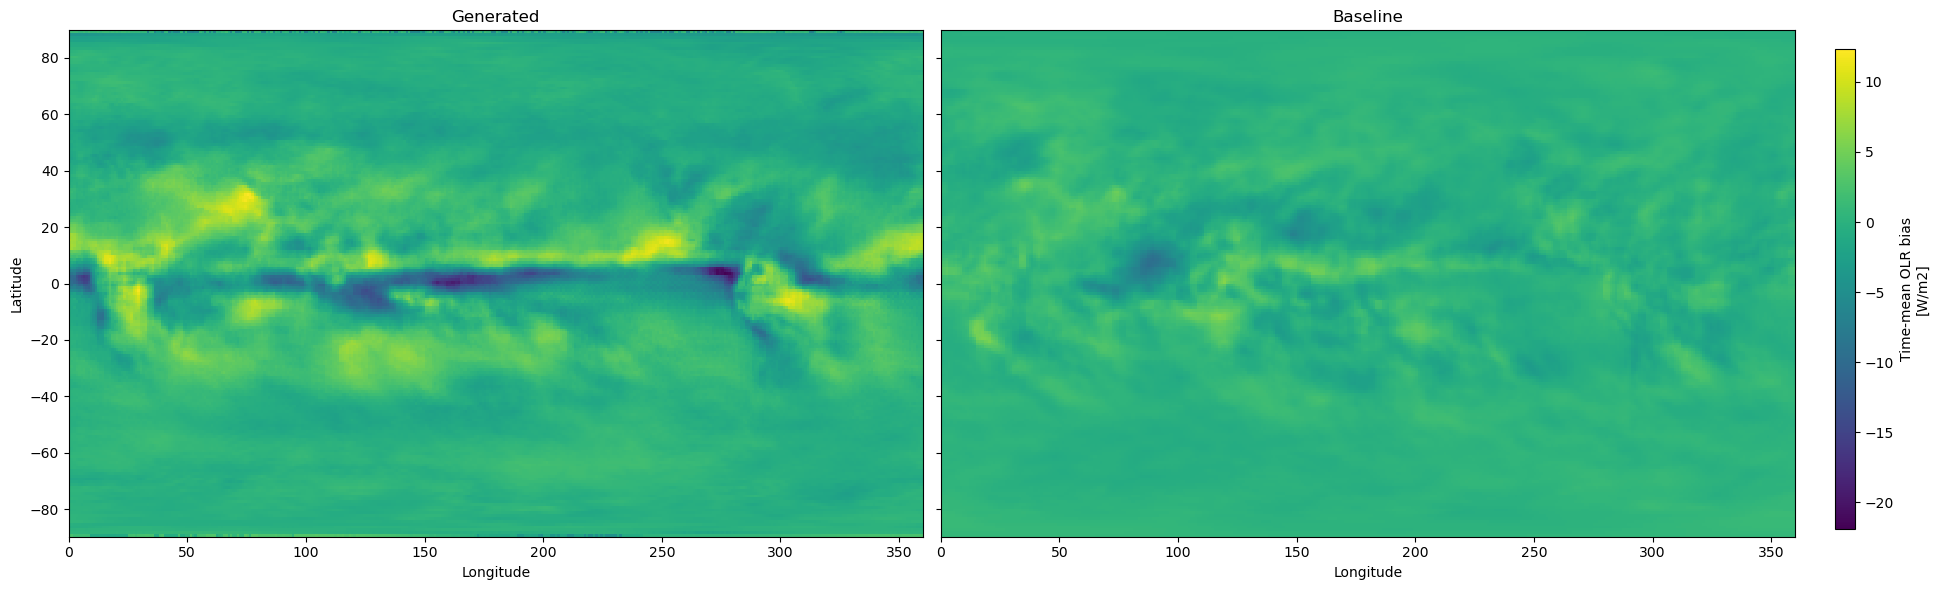

In [11]:
fig, axs = plot_time_mean_bias(time_mean_bias_FLUT, baseline_time_mean_bias_FLUT, 
                               var_name="OLR")
fig.show()

In [12]:
da_FSUT = ds["top_of_atmos_upward_shortwave_flux"]
time_mean_bias_FSUT = compute_time_mean_bias(
    da_FSUT.sel(source="prediction"),
    da_FSUT.sel(source="target")
)

[########################################] | 100% Completed | 41.2s


In [13]:
baseline_da_FSUT = baseline_ds["top_of_atmos_upward_shortwave_flux"]
baseline_time_mean_bias_FSUT = compute_time_mean_bias(
    baseline_da_FSUT,
    da_FSUT.sel(source="target")
)

[########################################] | 100% Completed |  1min 14.8s


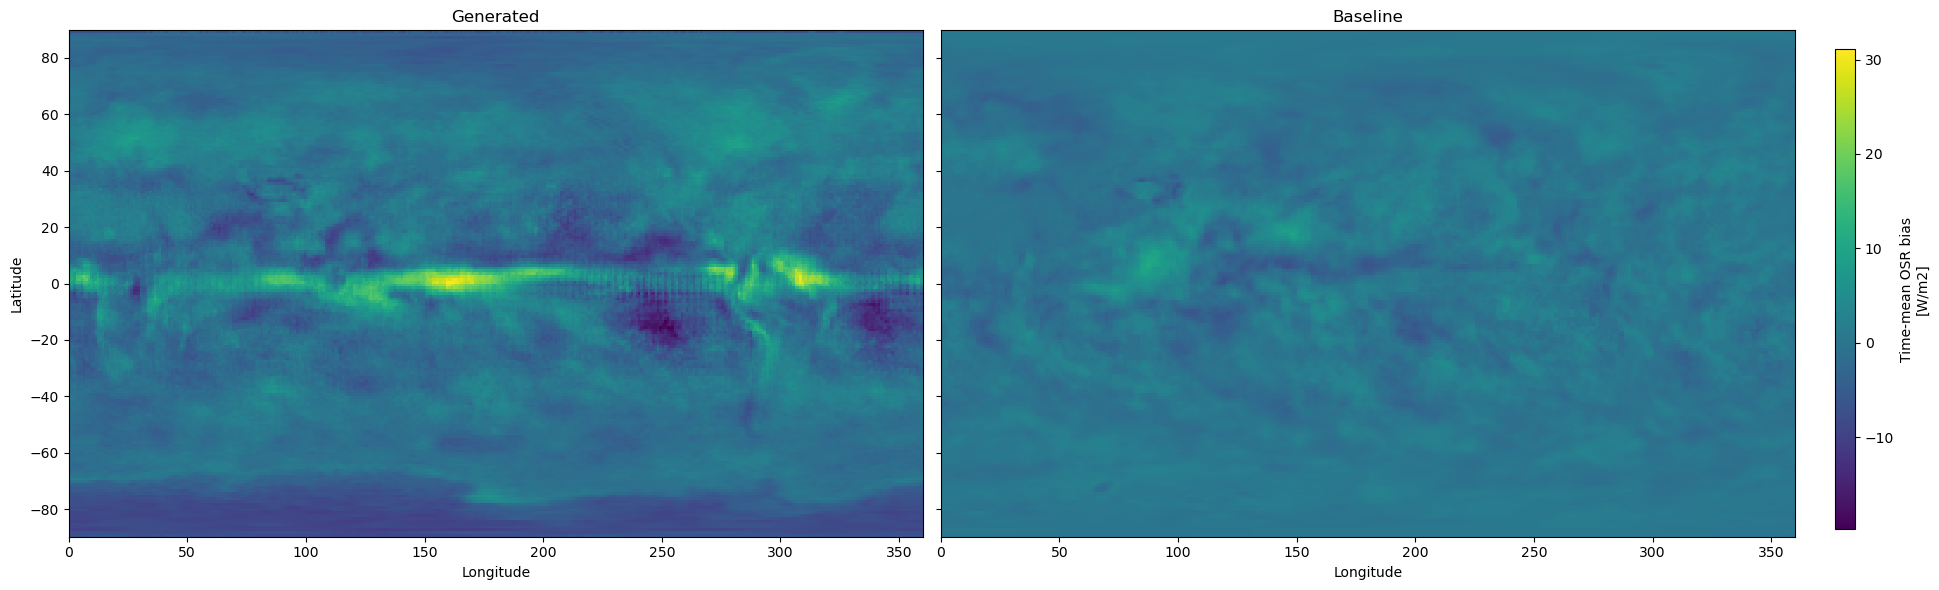

In [14]:
fig, axs = plot_time_mean_bias(time_mean_bias_FSUT, baseline_time_mean_bias_FSUT, 
                               var_name="OSR")
fig.show()